# Credit Risk Model Recalibration in Python
This notebook demonstrates how to train a logistic regression model for PD estimation and recalibrate it using actual default outcomes.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic historical data
n_samples = 1000
historical_data = pd.DataFrame({
    'Income': np.random.normal(50000, 15000, n_samples),
    'Age': np.random.randint(20, 70, n_samples),
    'DebtToIncome': np.random.uniform(0.1, 0.5, n_samples),
    'CreditScore': np.random.normal(700, 50, n_samples),
    'Default': np.random.binomial(1, 0.1, n_samples)  # 10% default rate
})

# Prepare features
X = historical_data[['Income', 'Age', 'DebtToIncome', 'CreditScore']]
y = historical_data['Default']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression model
logit_model = LogisticRegression(fit_intercept=True, penalty= None, solver= 'lbfgs') 
logit_model.fit(X_scaled, y)

# Store PD estimates
historical_data['PD_hat'] = logit_model.predict_proba(X_scaled)[:, 1]


In [4]:
# performa the wald test also for logit in sklearn manually
from scipy import stats

# Get the parameters
params = np.concatenate([logit_model.intercept_, logit_model.coef_.flatten()])

# Calculate the covariance matrix
X_design = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])
pred_probs = logit_model.predict_proba(X_scaled)[:, 1]
V = np.diag(pred_probs * (1 - pred_probs))
cov_matrix = np.linalg.inv(X_design.T @ V @ X_design)

# Calculate standard errors
standard_errors = np.sqrt(np.diag(cov_matrix))

# Calculate z-values
z_values = params / standard_errors

# Calculate p-values
p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_values]

# Wald test
wald_stats = (params / standard_errors) ** 2
wald_p_values = [1 - stats.chi2.cdf(w, 1) for w in wald_stats]

# Create a summary table
summary_df = pd.DataFrame({
    'Coefficient': params,
    'Std. Error': standard_errors,
    'z': z_values,
    'P>|z|': p_values,
    '[0.025': params - 1.96 * standard_errors,
    '0.975]': params + 1.96 * standard_errors
})

print(summary_df)


   Coefficient  Std. Error          z     P>|z|    [0.025    0.975]
0    -2.295480    0.111896 -20.514319  0.000000 -2.514797 -2.076163
1     0.141311    0.108410   1.303484  0.192410 -0.071173  0.353795
2    -0.027809    0.108554  -0.256177  0.797814 -0.240574  0.184956
3     0.032909    0.108763   0.302573  0.762215 -0.180266  0.246083
4     0.278730    0.110008   2.533716  0.011286  0.063113  0.494346


In [5]:
# train the model with logit in statsmodels
X_sm = sm.add_constant(X_scaled)
logit_model_sm = sm.Logit(y, X_sm)
result_sm = logit_model_sm.fit()
print(result_sm.summary())
historical_data['PD_hat_sm'] = result_sm.predict(X_sm)

Optimization terminated successfully.
         Current function value: 0.309591
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            4
Date:                 Do, 13 Feb 2025   Pseudo R-squ.:                 0.01390
Time:                        10:09:42   Log-Likelihood:                -309.59
converged:                       True   LL-Null:                       -313.96
Covariance Type:            nonrobust   LLR p-value:                   0.06824
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2955      0.112    -20.514      0.000      -2.515      -2.076
x1             0.1415      0.

In [7]:
# Train a Neural Network Model using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_tensor.shape[1], 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predict probabilities using the neural network model
model.eval()
with torch.no_grad():
    historical_data['PD_hat_nn'] = model(X_tensor).numpy()


# Compare the result of neural network with logit model in sklearn and statsmodels
from sklearn.metrics import roc_auc_score

# Calculate AUC for sklearn logistic regression
auc_sk = roc_auc_score(y, historical_data['PD_hat'])
print(f'AUC for sklearn logistic regression: {auc_sk:.4f}')

# Calculate AUC for statsmodels logistic regression
auc_sm = roc_auc_score(y, historical_data['PD_hat_sm'])
print(f'AUC for statsmodels logistic regression: {auc_sm:.4f}')

# Calculate AUC for PyTorch neural network
auc_nn = roc_auc_score(y, historical_data['PD_hat_nn'])
print(f'AUC for PyTorch neural network: {auc_nn:.4f}')

Epoch [10/100], Loss: 0.6297
Epoch [20/100], Loss: 0.4729
Epoch [30/100], Loss: 0.3762
Epoch [40/100], Loss: 0.3332
Epoch [50/100], Loss: 0.3233
Epoch [60/100], Loss: 0.3217
Epoch [70/100], Loss: 0.3195
Epoch [80/100], Loss: 0.3172
Epoch [90/100], Loss: 0.3154
Epoch [100/100], Loss: 0.3142
AUC for sklearn logistic regression: 0.5984
AUC for statsmodels logistic regression: 0.5984
AUC for PyTorch neural network: 0.5669


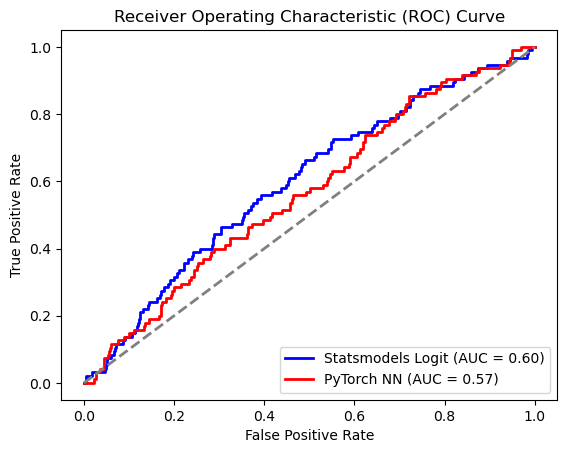

In [ ]:
# Compare the ROC curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for statsmodels logistic regression
fpr_sm, tpr_sm, _ = roc_curve(y, historical_data['PD_hat_sm'])
roc_auc_sm = auc(fpr_sm, tpr_sm)

# Calculate ROC curve for PyTorch neural network
fpr_nn, tpr_nn, _ = roc_curve(y, historical_data['PD_hat_nn'])
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure()

# Plot ROC curve for statsmodels logistic regression
plt.plot(fpr_sm, tpr_sm, color='blue', lw=2, label=f'Statsmodels Logit (AUC = {roc_auc_sm:.2f})')

# Plot ROC curve for PyTorch neural network
plt.plot(fpr_nn, tpr_nn, color='red', lw=2, label=f'PyTorch NN (AUC = {roc_auc_nn:.2f})')

# Plot the diagonal line (no skill classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# test5

In [7]:
# train the model with GLM class in statsmodels using the same data
X_glm = sm.add_constant(X_scaled)
logit_glm = sm.GLM(y, X_glm, family=sm.families.Binomial())
result_glm = logit_glm.fit()
historical_data['PD_hat_glm'] = result_glm.predict(X_glm)

In [ ]:
# use the logit model in skorecard
from skorecard.linear_model import LogisticRegression
from skorecard.bucketers import bucketers
from skorecard.preprocessing import WoeEncoder
from skorecard.reporting import plotting

# regression with input without bucketing and woe encoding
logit_skorecard = LogisticRegression(penalty= None, solver='lbfgs', calculate_stats=True)
logit_skorecard.fit(X_scaled, y)
historical_data['PD_hat_skorecard'] = logit_skorecard.predict_proba(X_scaled)[:, 1]
logit_skorecard.get_stats()

# regression with input with bucketing and woe encoding
bucketing = bucketers.UserInputBucketer(variables=['Income', 'Age', 'DebtToIncome', 'CreditScore'])



d:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Coef.,Std.Err,z,P>|z|
const,-2.295480,0.111896,-20.514319,1.604000e-93
x0,0.141311,0.108410,1.303484,1.924097e-01
x1,-0.027809,0.108554,-0.256177,7.978139e-01
x2,0.032909,0.108763,0.302573,7.622154e-01
x3,0.278730,0.110008,2.533716,1.128602e-02


In [ ]:
# Generate synthetic current data
current_data = pd.DataFrame({
    'Income': np.random.normal(52000, 14000, n_samples),
    'Age': np.random.randint(22, 68, n_samples),
    'DebtToIncome': np.random.uniform(0.1, 0.6, n_samples),
    'CreditScore': np.random.normal(710, 55, n_samples),
    'Actual_Default': np.random.binomial(1, 0.12, n_samples)  # 12% default rate
})

# Standardize using the same scaler
X_current = current_data[['Income', 'Age', 'DebtToIncome', 'CreditScore']]
X_current_scaled = scaler.transform(X_current)

# Predict PDs using the original model
current_data['PD_hat'] = logit_model.predict_proba(X_current_scaled)[:, 1]


In [5]:
# Fit recalibration model: Actual default ~ PD_hat
X_recalibration = sm.add_constant(current_data[['PD_hat']])  # Add intercept
recalibration_model = sm.Logit(current_data['Actual_Default'], X_recalibration).fit()

# Predict recalibrated PDs
current_data['PD_recalibrated'] = recalibration_model.predict(X_recalibration)


Optimization terminated successfully.
         Current function value: 0.353210
         Iterations 6


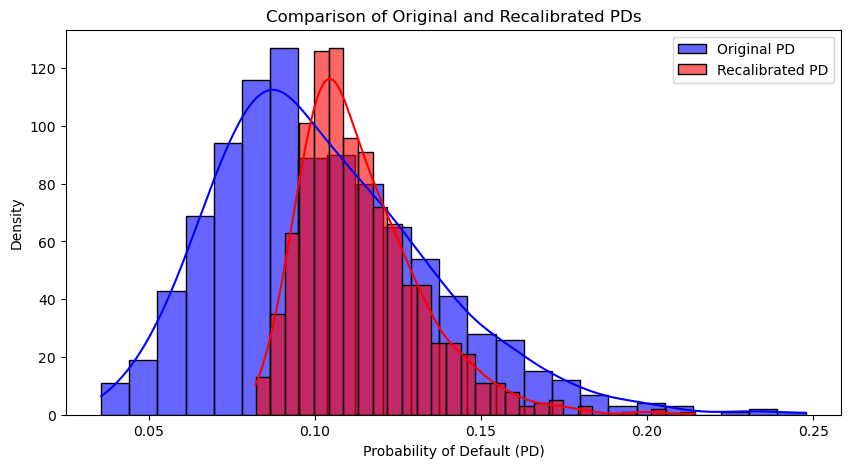

In [6]:
# Plot histograms of PD_hat vs PD_recalibrated
plt.figure(figsize=(10,5))
sns.histplot(current_data['PD_hat'], label='Original PD', kde=True, color='blue', alpha=0.6)
sns.histplot(current_data['PD_recalibrated'], label='Recalibrated PD', kde=True, color='red', alpha=0.6)
plt.xlabel('Probability of Default (PD)')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of Original and Recalibrated PDs')
plt.show()
